In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pyspark
import numpy as np
import string
import re
from pyspark.sql.functions import isnan, when, count, col
import pyspark.sql.functions as F

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import CountVectorizer, IDF
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType, IntegerType, FloatType, DoubleType, LongType
from pyspark.sql import Row
import pickle
PUNCTUATION = set(string.punctuation)
STOPWORDS = set(stopwords.words('english'))

In [3]:
df = pd.read_csv('data/sentiment_analysis_subset.csv')\
                .drop(['Unnamed: 0', 'Id'],axis=1)

In [4]:
df.head()

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Summary_len,Text_len,Summary_cleaned
0,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,not as advertised,"""product arrived labeled as jumbo salted peanu...",3,39,[advertised]
1,B0009XLVG0,A327PCT23YH90,LT,1,1,1,1339545600,my cats are not fans of the new food,my cats have been happily eating felidae plati...,9,80,"[cats, fans, new, food]"
2,B0019CW0HE,A2P6ACFZ8FTNVV,Melissa Benjamin,0,1,1,1331164800,bad,i fed this to my golden retriever and he hated...,1,37,[bad]
3,B002HQAXUW,A17ESTP5T7T1PH,Bumbeda1,1,1,1,1324944000,rip off price,these singles sell for $2.50 - $3.36 at the st...,3,46,"[rip, price]"
4,B000ITVLE2,ARTBQH9WOZTIV,"""Billy Wilson """"amzrview""""""",0,4,1,1269216000,tasteless but low calorie,seriously this product was as tasteless as the...,4,48,"[tasteless, low, calorie]"


In [5]:
def clean_text(text, remove_stopwords=True, rejoin=True):
    text = text.lower()
    # Remove tags and characters
    cleanr = re.compile("<.*?>|[*`\'\"+=.’‘-]|http\S+|href|span|class")
    text = re.sub(cleanr, '', text)
    tokens = word_tokenize(text)
    tokens = [w for w in tokens if w not in PUNCTUATION]
    if remove_stopwords==True:
        tokens = [w for w in tokens if w not in STOPWORDS]
    if rejoin==True:
        tokens = ' '.join(tokens)
    return tokens

In [6]:
df.Summary = df.Summary.apply(clean_text, args=(False,True))
df.Text = df.Text.apply(clean_text, args=(True,True))

In [7]:
text_df = df[['Text', 'Summary', 'Score']]

In [8]:
text_df.Score = text_df.Score.replace(1,0)
text_df.Score = text_df.Score.replace(5,1)

/Users/kylecaron/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


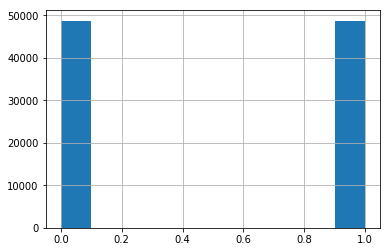

In [9]:
text_df.Score.hist()

# Model

In [10]:
X = text_df['Text']
y = text_df['Score']


X_train, X_test, y_train, y_test = train_test_split(
    X,y, train_size=0.75, shuffle=True, stratify=y, random_state=100)

/Users/kylecaron/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [11]:
BNB_idf = BernoulliNB()
tfidf = TfidfVectorizer(list(X_train),
                        lowercase=True, stop_words='english')

In [12]:
idf_X_train = tfidf.fit_transform(X_train)
idf_X_test = tfidf.transform(X_test)

In [13]:
from sklearn.model_selection import cross_val_score

In [15]:
BNB_idf.fit(idf_X_train, y_train)
np.mean(cross_val_score(BNB_idf, idf_X_train, y_train, cv=10))

0.8999412626571124

# Other Models

In [16]:
from sklearn.linear_model import SGDClassifier

In [17]:
SVM = SGDClassifier()
SVM.fit(idf_X_train, y_train)

/Users/kylecaron/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [18]:
np.mean(cross_val_score(SVM, idf_X_train, y_train, cv=10))

/Users/kylecaron/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


0.9081574890631139

In [19]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


In [20]:
from sklearn.linear_model import LogisticRegression

In [21]:
lr = LogisticRegression()
lr.fit(idf_X_train, y_train)

/Users/kylecaron/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

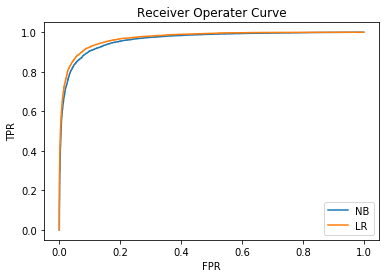

In [29]:
fpr1, tpr1, thresholds = roc_curve(y_test,
                BNB_idf.predict_proba(idf_X_test)[:,1])
# fpr2, tpr2, thresholds = roc_curve(y_test,
#                 SVM.predict(idf_X_test))
fpr3, tpr3, thresholds = roc_curve(y_test,
                lr.predict_proba(idf_X_test)[:,1])

plt.plot(fpr1,tpr1, label = 'NB')
# plt.plot(fpr2,tpr2, label='SVM')
plt.plot(fpr3,tpr3, label = 'LR')
plt.title('Receiver Operater Curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

In [26]:
print('TF-IDF AUC: {}'.format(roc_auc_score(
    y_test,BNB_idf.predict(idf_X_test))))

print('SVM AUC: {}'.format(
    roc_auc_score(y_test, SVM.predict(idf_X_test))))

print('LR AUC: {}'.format(
    roc_auc_score(y_test, lr.predict(idf_X_test))))

TF-IDF AUC: 0.8993157910799048
SVM AUC: 0.9078861981301124
LR AUC: 0.9141202918023299


# Grid Search

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline


In [72]:
IDF = TfidfVectorizer(lowercase=True, stop_words='english')
BNB = BernoulliNB()

pipe = Pipeline(steps=[('IDF', IDF), ('BNB', MNB)])

param_dict = {'BNB__alpha':[0.001, 0.1,1, 0.9, 0.78, 0.5, 0.16,0.4],
 'IDF__min_df':[1, 0.05, 0.1],
 'IDF__max_df':[1.0, 0.83, 0.95]
}
BNB_grid = GridSearchCV(pipe, param_dict, scoring='roc_auc', 
                        n_jobs=-1)
BNB_grid.fit(X_train, y_train)

/Users/kylecaron/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('IDF', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...rue,
        vocabulary=None)), ('BNB', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'BNB__alpha': [0.001, 0.1, 1, 0.9, 0.78, 0.5, 0.16, 0.4], 'IDF__min_df': [1, 0.05, 0.1], 'IDF__max_df': [1.0, 0.83, 0.95]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [32]:
BNB_grid.best_params_


{'BNB__alpha': 1, 'IDF__max_df': 1.0, 'IDF__min_df': 1}

In [33]:
BNB_grid.best_params_
BNB_grid.best_score_

0.9610757504043973

### SVM Grid

In [ ]:
IDF = TfidfVectorizer()
SVM = SGDClassifier()

pipe = Pipeline(steps=[('IDF', IDF), ('SVM', SVM)])

param_dict = {'SVM__alpha':[0.0001,0.001,0.01, 0.05, 0.1],
              'SVM__loss':['hinge','log'],
              'SVM__penalty':['l2', 'elasticnet'],
              'IDF__min_df':[1, 0.05, 0.1],
}

SVM_grid = GridSearchCV(pipe, param_dict, scoring='roc_auc', n_jobs=-1)
SVM_grid.fit(X_train, y_train)

In [ ]:
SVM_best_params = SVM_grid.best_params_
SVM_grid.best_score_

# Logistic Regression Grid Search

In [34]:
IDF = TfidfVectorizer(lowercase=True, stop_words='english')
LR = LogisticRegression()

pipe = Pipeline(steps=[('IDF', IDF), ('LR', LR)])

param_dict = {'LR__C':[0.001, 1, 0.9, 0.1, 0.05],
 'IDF__min_df':[1 ],
 'IDF__max_df':[1.0],
}
LR_grid = GridSearchCV(pipe, param_dict, scoring='roc_auc', 
                        n_jobs=-1)
LR_grid.fit(X_train, y_train)

/Users/kylecaron/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/kylecaron/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('IDF', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'LR__C': [0.001, 1, 0.9, 0.1, 0.05], 'IDF__min_df': [1], 'IDF__max_df': [1.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [35]:
LR_grid.best_score_

0.9685806151756845

In [36]:
import seaborn as sns

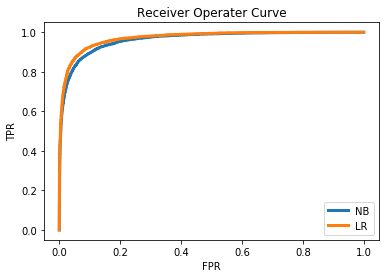

In [39]:
fpr1, tpr1, thresholds = roc_curve(y_test,
                BNB_grid.predict_proba(X_test)[:,1])
# fpr2, tpr2, thresholds = roc_curve(y_test,
#                 SVM_grid.predict(X_test))
fpr3, tpr3, thresholds = roc_curve(y_test,
                LR_grid.predict_proba(X_test)[:,1])


plt.plot(fpr1,tpr1, label = 'NB',linewidth=3)
# plt.plot(fpr2,tpr2, label='SVM', linewidth=3)
plt.plot(fpr3,tpr3, label='LR', linewidth=3)
plt.title('Receiver Operater Curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

In [43]:
#print('\nSVM Accuracy on Test Set: {}%'.format(round(np.mean(y_test==SVM_grid.predict(X_test)),3)*100))
print('BNB Accuracy on Test Set: {}%'.format(round(BNB_grid.score(X_test,y_test),3)*100))

BNB Accuracy on Test Set: 96.3%


In [55]:
#print('\nSVM Accuracy on Test Set: {}%'.format(round(SVM_grid.score(X_test,y_test),3)*100))
#print('\nSVM ROC-AUC on Test Set: {}%'.format(round(roc_auc_score(
#    y_test,SVM_grid.predict(X_test)),3)*100))

print('BNB Accuracy on Test Set: {}%'.format(round(np.mean(y_test == BNB_grid.predict(X_test)),3)*100))
print('BNB ROC-AUC on Test Set: {}'.format(round(
    roc_auc_score(y_test,BNB_grid.predict_proba(X_test)[:,1]),3)))

print('LR Accuracy on Test Set: {}%'.format(round(np.mean(y_test == LR_grid.predict(X_test)),3)*100))
print('LR ROC-AUC on Test Set: {}'.format(round(
    roc_auc_score(y_test,LR_grid.predict_proba(X_test)[:,1]),3)))


BNB Accuracy on Test Set: 89.7%
BNB ROC-AUC on Test Set: 0.963
LR Accuracy on Test Set: 91.4%
LR ROC-AUC on Test Set: 0.971


In [57]:
from sklearn.metrics import confusion_matrix
from src.util import plot_confusion_matrix

Confusion matrix
[[11201  1161]
 [  991 11030]]


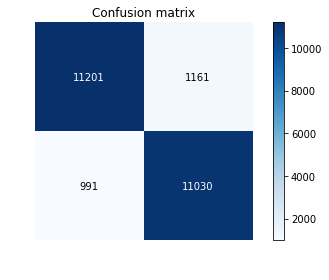

In [64]:
plot_confusion_matrix(y_test, SVM_grid.predict(X_test))

Confusion matrix
[[10873  1193]
 [ 1319 10998]]


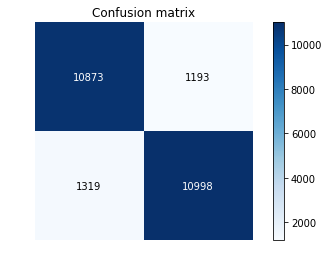

In [65]:
plot_confusion_matrix(y_test, BNB_grid.predict(X_test))

Confusion matrix
[[11205  1107]
 [  987 11084]]


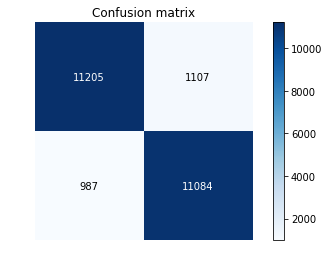

In [59]:
plot_confusion_matrix(y_test, LR_grid.predict(X_test))

In [61]:
def FPR(confusion_matrix):
    tpr = confusion_matrix[0,1]/(confusion_matrix[0,1]+confusion_matrix[1,1])
    return tpr

def TPR(confusion_matrix):
    tpr = confusion_matrix[0,0]/(confusion_matrix[0,0]+confusion_matrix[0,1])
    return tpr

# MNB

In [76]:
cm_BNB = confusion_matrix(y_test, BNB_grid.predict(X_test)).T

In [77]:
print(FPR(cm_BNB)*100) 
print(TPR(cm_BNB)*100)

9.785907636781232
90.11271340958064


# LR

In [66]:
cm_LR = confusion_matrix(y_test, LR_grid.predict(X_test)).T

In [67]:
print(FPR(cm_LR)*100) 
print(TPR(cm_LR)*100)

9.080469198589123
91.00877192982456


# SVM

In [131]:
print(11163/(11163+1029))
print(1158/(1158+11033))

0.9156003937007874
0.09498810597982119


In [175]:
from sklearn.naive_bayes import BernoulliNB

In [176]:
NB = BernoulliNB(alpha=1)

In [177]:
NB.fit(idf_X_train, y_train)

BernoulliNB(alpha=1, binarize=0.0, class_prior=None, fit_prior=True)

In [178]:
NB.score(idf_X_test, y_test)

0.8996431940286265

In [179]:
nb = MultinomialNB(alpha=1)
nb.fit(idf_X_train, y_train)
nb.score(idf_X_test, y_test)

0.8975925849977443

In [188]:
r1 = """Mattress is super comfortable and unlike some other models, cool all night long. 
Once delivered, installation was quick and easy. It came in a duffle that was slightly damaged. 
It appeared to have been dragged during delivery, but it is quite heavy. We were concerned about the smell due 
to reviews that we had read, but we noticed no odor and were able to use the mattress the same day. The pillows are 
very thick, too thick for our liking, but they have a zippered closure that allows you to remove foam for 
individualized comfort. The NECTAR mattress is one of the best purchases we've ever made"""

r2 = """Pretty ideal mattress, I was looking online for awhile which one to buy and decided on this one. 
It’s a bit firm which I love, and I sleep perfectly through the night, no pain, no tossing and turning, 
it’s still cold where I live so I can’t attest to it running too warm or not but so far so good. The free pillows 
aren’t my favorite, I wouldn’t say why yet, I think they still have a bit of a smell I haven’t aired them out well, 
but they aren’t my primary pillow so it’s fine... plus they were ‘free’ in the purchase so I can’t really complain."""

r3 = '''Before the expiration date the bars all moldy. Horrible blue. What a waste of money. 
Will not buy from this seller ever again.'''

r4 = '''Terrible Every single can -not one or two or ten- of the twelve was dented. Every. Single. Can.'''

r5 = '''When the box of 12 arrived - 6 cans were dented so badly, I don't know whether to use them. 
Hunts fire roasted diced tomatoes. That is the first time that has happened'''

r6 = '''I have recently been put on a no salt diet and cook with diced tomatoes a lot. 
I did not know what to do as finding no salt products in the store is difficult at best. 
These have saved a lot of my recipes and taste good as well.'''

r7 ='''These canned tomatoes have a wonderful flavor and taste great used in so many dishes. 
I try to keep a few cans in my pantry for quick and easy meals.
'''

In [189]:
clean_text(r1)



'mattress super comfortable unlike models cool night long delivered installation quick easy came duffle slightly damaged appeared dragged delivery quite heavy concerned smell due reviews read noticed odor able use mattress day pillows thick thick liking zippered closure allows remove foam individualized comfort nectar mattress one best purchases weve ever made'

In [212]:
print(r3)
print('spoiled product')

Before the expiration date the bars all moldy. Horrible blue. What a waste of money. 
Will not buy from this seller ever again.
spoiled product


In [214]:
print(r7)
print('great product')

These canned tomatoes have a wonderful flavor and taste great used in so many dishes. 
I try to keep a few cans in my pantry for quick and easy meals.

great product
